In [ ]:
# Standar Library
import re
import string

# Third-party Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
import pandas as pd

# Local directory
data = pd.read_csv('review_hotel.csv')

In [ ]:
data.shape
data.sample(5)

,review_id,review_text,category
2565,5b35e869a2a78ce1b89eed3d6d1418db,saya sangat kecewa dengan fasilitas yang didap...,0
13008,c18256a7dedc9bf96ba185abd8d4ba9d,"Sepi , karyawan sedikit , kamar luas tapi koto...",0
1727,1cf690b2d0b75e2471d0f660deef3069,handuk TIDAK PERNAH TERSEDIA!!!\n,0
12121,f95bb63ea9e3a8e347e37323146317dd,Kamar memuaskan..ruang lobby banyak nyamuk.,1
13413,4d4518d2871884eacef3fe56145c0fe9,"agak ribut, terlalu diperhatikan gerak gerik k...",0


In [ ]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    # text = stemmer.stem(text)
    return text

In [ ]:
data["cleaned_text"] = data["review_text"].apply(preprocess_text)
data.head()

,review_id,review_text,category,cleaned_text
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,penginapannya rapi bersih suasana tenang pelay...
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,wifi tidak sampai kamar tidak tersedia heater ...
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,lantai kamar mandi kotor bau dan seperti sdh j...
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,wc jorok kasur tidak dibersihkan handuk tidak ...
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,bocor lagi


Dapatkan teks dan label

In [ ]:
target = data["category"]
features_text = data["cleaned_text"]

Input Pipeline

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(features_text, target, random_state=42)

In [ ]:
#TF Dataset
BATCH_SIZE = 32

In [ ]:
# Ubah input menjadi objek tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Terapkan shuffle, batch dan prefetch pada dataset
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Melihat isi dataset
for feat, tar in train_dataset.take(1):
    print(feat[:3])
    print(tar[:3])

tf.Tensor(
[b'lantai kamar mandi dan lanta kamar kurang bersih terasa licin '
 b'kamar oke lokasi oke tp sarapannya kurang enak\xf0\x9f\x99\x81 '
 b'bad place'], shape=(3,), dtype=string)
tf.Tensor([0 0 0], shape=(3,), dtype=int64)


In [ ]:
#Text Encoder
max_features = 10000      # Jumlah kosakata
embedding_dim = 16        # Jumlah dimensi dalam word embedding

In [ ]:
# Buat text vectorizer
encoder = keras.layers.TextVectorization(max_tokens=max_features)

# Latih tokenizer pada data teks
encoder.adapt(train_dataset.map(lambda feat, tar: feat))

In [ ]:
# Tokenisasi data teks
encoder(feat)[:3]

<tf.Tensor: shape=(3, 47), dtype=int64, numpy=
array([[  74,    2,    9,    4, 4738,    2,    7,   13,  411,  571,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   2,  119,   79,  119,   67,  421,    7, 9985,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 239,  515,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           

**Model Building: Neural Network** 

Bangun model


In [ ]:
# Buat model sequential (berurutan)
model = keras.Sequential()
model.add(encoder)
model.add(keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()), 
    output_dim=embedding_dim, 
    mask_zero=True)
)
model.add(keras.layers.LSTM(16, return_sequences=True))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Tentukan loss, optimizer dan metrik yang akan digunakan
model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["acc"])

Struktur Model

In [ ]:
# Melihat arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, None, 16)          2112      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                        

Bentuk Model


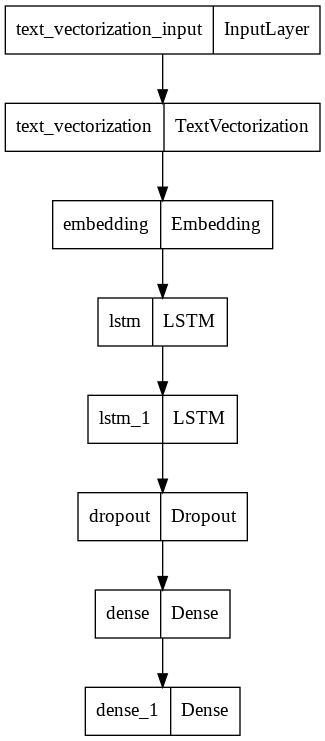

In [ ]:
# Melihat Diagram Model
keras.utils.vis_utils.plot_model(model, "model.png")

Latih Model

In [ ]:
# Melatih model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
349/349 [==============================] - 38s 78ms/step - loss: 0.3023 - acc: 0.9078 - val_loss: 0.1793 - val_acc: 0.9499
Epoch 2/10
349/349 [==============================] - 24s 70ms/step - loss: 0.1837 - acc: 0.9465 - val_loss: 0.1559 - val_acc: 0.9537
Epoch 3/10
349/349 [==============================] - 25s 70ms/step - loss: 0.1583 - acc: 0.9546 - val_loss: 0.1507 - val_acc: 0.9540
Epoch 4/10
349/349 [==============================] - 25s 72ms/step - loss: 0.1453 - acc: 0.9571 - val_loss: 0.1516 - val_acc: 0.9556
Epoch 5/10
349/349 [==============================] - 25s 71ms/step - loss: 0.1359 - acc: 0.9593 - val_loss: 0.1505 - val_acc: 0.9553
Epoch 6/10
349/349 [==============================] - 25s 70ms/step - loss: 0.1314 - acc: 0.9606 - val_loss: 0.1540 - val_acc: 0.9540
Epoch 7/10
349/349 [==============================] - 25s 71ms/step - loss: 0.1229 - acc: 0.9629 - val_loss: 0.1507 - val_acc: 0.9545
Epoch 8/10
349/349 [==============================] - 25s 71ms

Evaluasi Model

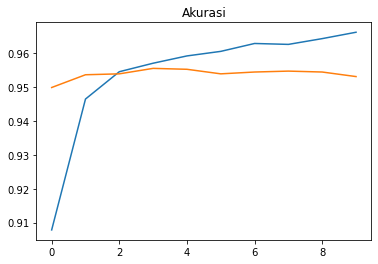

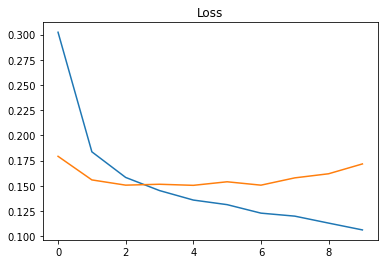

In [ ]:
plt.figure()
plt.title("Akurasi")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

plt.figure()
plt.title("Loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.show()

Prediksi Model

In [ ]:
contoh_review = ["lokasi strategis pusat kota, nyaman"]
prediksi = model.predict(contoh_review) # Probabilitas
prediksi.squeeze()  # diatas 0.5 berarti label 1 atau sentimen positif, begitu juga sebaliknya

array(0.9957977, dtype=float32)

In [ ]:
if prediksi.squeeze()>0.5:
  print(prediksi.squeeze())
  print("Review positif")
else:
  print(prediksi.squeeze())
  print("Review negatif")

0.9957977
Review positif


In [ ]:
model.save_weights('mymodel_weights')
model.save('mymodel',save_format=tf)

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
tf.keras.models.load_model("mymodel")

In [ ]:
contoh_review = ["lokasi strategis pusat kota, nyaman"]
prediksi = model.predict(contoh_review) # Probabilitas
prediksi.squeeze()
if prediksi.squeeze()>0.5:
  print(prediksi.squeeze())
  print("Review positif")
else:
  print(prediksi.squeeze())
  print("Review negatif")

0.9957977
Review positif
